## Import packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [49]:
from scipy import stats
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RepeatedKFold
import statistics

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

## Read data + clean data

In [3]:
df = pd.read_csv('BankMarketingAdditional-1.csv', sep=';')

In [4]:
# change the output to numeric type 
df['y'] = df.y.apply(lambda x: 0 if x=='no' else 1)

In [5]:
# see the distribution of data
df.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [6]:
# data overview 
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [7]:
# see the null and missing values in the dataset
df_null = pd.concat([df.isnull().sum(), df.eq('').sum()],keys=['Nulls','Empty'],axis=1)
df_null

,Nulls,Empty
age,0,0
job,0,0
marital,0,0
education,0,0
default,0,0
housing,0,0
loan,0,0
contact,0,0
month,0,0
day_of_week,0,0


In [8]:
# feature selection: drop the columns with no meaningful impact to the prediction
df.drop(['contact','month','day_of_week','duration'], axis='columns', inplace=True)

In [9]:
# feature engineering: change according to the data description 
df['pdays'] = df['pdays'].replace([999],0)

In [10]:
# encode categorical data field
# save categorical data with corresponding numbers for further reference
obj_column = df.dtypes[df.dtypes == 'object'].index

mapingdf = pd.DataFrame()
for column in obj_column:
    labelencoder = LabelEncoder()
    df[column] = labelencoder.fit_transform(df[column])
    mapingdf[column] = df[column]
    mapingdf['_' + column] =  labelencoder.inverse_transform(df[column])
    
mapingdf.head()

,job,_job,marital,_marital,education,_education,default,_default,housing,_housing,loan,_loan,poutcome,_poutcome
0,3,housemaid,1,married,0,basic.4y,0,no,0,no,0,no,1,nonexistent
1,7,services,1,married,3,high.school,1,unknown,0,no,0,no,1,nonexistent
2,7,services,1,married,3,high.school,0,no,2,yes,0,no,1,nonexistent
3,0,admin.,1,married,1,basic.6y,0,no,0,no,0,no,1,nonexistent
4,7,services,1,married,3,high.school,0,no,0,no,2,yes,1,nonexistent


In [11]:
# final dataframe
df.head()

,age,job,marital,education,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [12]:
# overview of variabels correlation 
df.corr().y.sort_values()

nr.employed      -0.354678
euribor3m        -0.307771
emp.var.rate     -0.298334
cons.price.idx   -0.136211
default          -0.099352
campaign         -0.066357
loan             -0.004909
housing           0.011552
job               0.025122
age               0.030399
marital           0.046203
cons.conf.idx     0.054878
education         0.057799
poutcome          0.129789
previous          0.230181
pdays             0.267088
y                 1.000000
Name: y, dtype: float64

## Save to final train and test data

In [13]:
# split the whole dataset for training and testing purpose 
# the splited y_train and y_test are hold out data (real-world data)
X_train, X_test, y_train, y_test = train_test_split(df.drop('y',axis=1),
                                                    df['y'],
                                                    test_size=0.3, random_state = 42,
                                                    stratify= df['y'])

In [14]:
# show the shape of training and testing data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28831, 16), (28831,), (12357, 16), (12357,))

In [15]:
# save the final training data to train_data.csv
# save the final hold out data to test_data.csv
training_data = pd.concat([X_train, y_train], axis = 1, join = "inner")
testing_data = pd.concat([X_test, y_test], axis = 1, join = "inner")

training_data.to_csv('train_data.csv', index = False)
testing_data.to_csv('test_data.csv', index = False)

## Use train data to fit models

In [16]:
#reload the train data
train_df = pd.read_csv('train_data.csv')    

In [17]:
# resplit the train data to training part and validation part (for model testing)
train_x, test_x, train_y, test_y = train_test_split(train_df.drop('y',axis=1),
                                                    train_df['y'],
                                                    test_size=0.33, random_state = 42,
                                                    stratify= train_df['y'])

In [18]:
# show the shape of the train and validation data
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((19316, 16), (9515, 16), (19316,), (9515,))

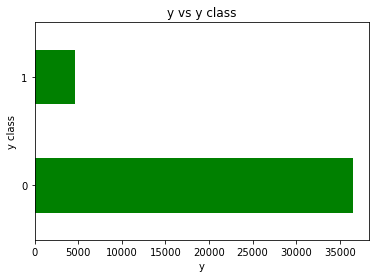

0    36548
1     4640
Name: y, dtype: int64


In [19]:
# plot the imbalanced data
plot_status_numberinit = df['y'].value_counts().plot(title = 'y vs y class', kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("y")
plot_status_numberinit.set_ylabel("y class")
plt.show()
print(df['y'].value_counts())

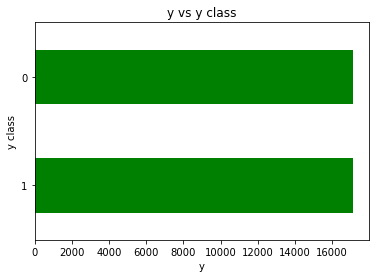

In [20]:
# oversample the minority class, using the SMOTE method
oversample = SMOTE()
new_train_X, new_train_y = oversample.fit_resample(train_x, train_y)

plot_status_numberinit = new_train_y.value_counts().plot(title = 'y vs y class', kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("y")
plot_status_numberinit.set_ylabel("y class")
plt.show()

In [21]:
# return the mean accuracy of given test data and labels
def fit_model (model):
    classifier = model()  
    classifier.fit(new_train_X, new_train_y)
    print("training accuracy is:",classifier.score(new_train_X, new_train_y))
    print("testing accuracy is:",classifier.score(test_x, test_y))   
    return classifier
    
# calculate precision, recall, fscore, and support score for the model
def prfs (trained_model):
    pred_label = trained_model.predict(test_x)
    print("When positive class refers to \"running\", the precision, recall, f_measure and support for the model is :",
          precision_recall_fscore_support(test_y, pred_label, average = "binary"))

# calculate the roc graph and auc score on parameters
def roc_auc(trained_model):
    plot_roc_curve(trained_model, test_x, test_y)
    roc_auc_score(test_y,trained_model.predict(test_x))
    
# calculate the cross validation to train better models
def cv (trained_model):
    cv = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 1)   #create the cross_validation proces
    scores = cross_val_score(trained_model, train_x, train_y, scoring = "accuracy", cv = cv, n_jobs = -1)
    # result = cross_validate(trained_model)
    print("Accuracy: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

### SCV

In [22]:
svc1 = fit_model(SVC)

training accuracy is: 0.7100058343057176
testing accuracy is: 0.7162375197057278


In [23]:
cv(svc1)   

Accuracy: 0.887 (0.007)


In [24]:
prfs(svc1)

When positive class refers to "running", the precision, recall, f_measure and support for the model is : (0.2420785804816223, 0.7126865671641791, 0.36140018921475875, None)


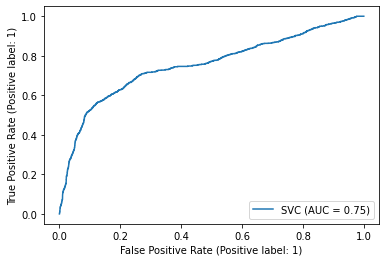

In [25]:
roc_auc(svc1)

### Decision tree

In [26]:
dt1 = fit_model(DecisionTreeClassifier)

training accuracy is: 0.9976371061843641
testing accuracy is: 0.8129269574356279


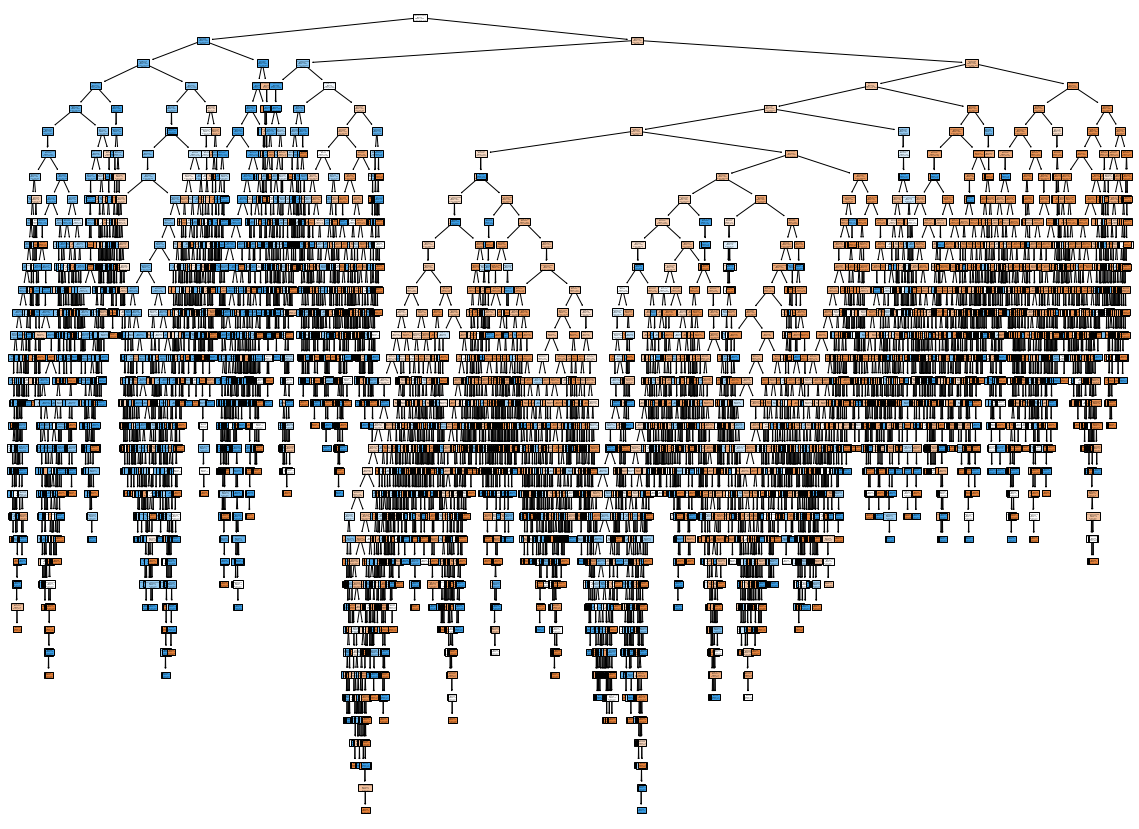

In [27]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,15))
plot_tree(dt1,
          feature_names= df.drop('y', axis=1).columns,  
          class_names= ['yes','no'],
          filled=True)
plt.show()

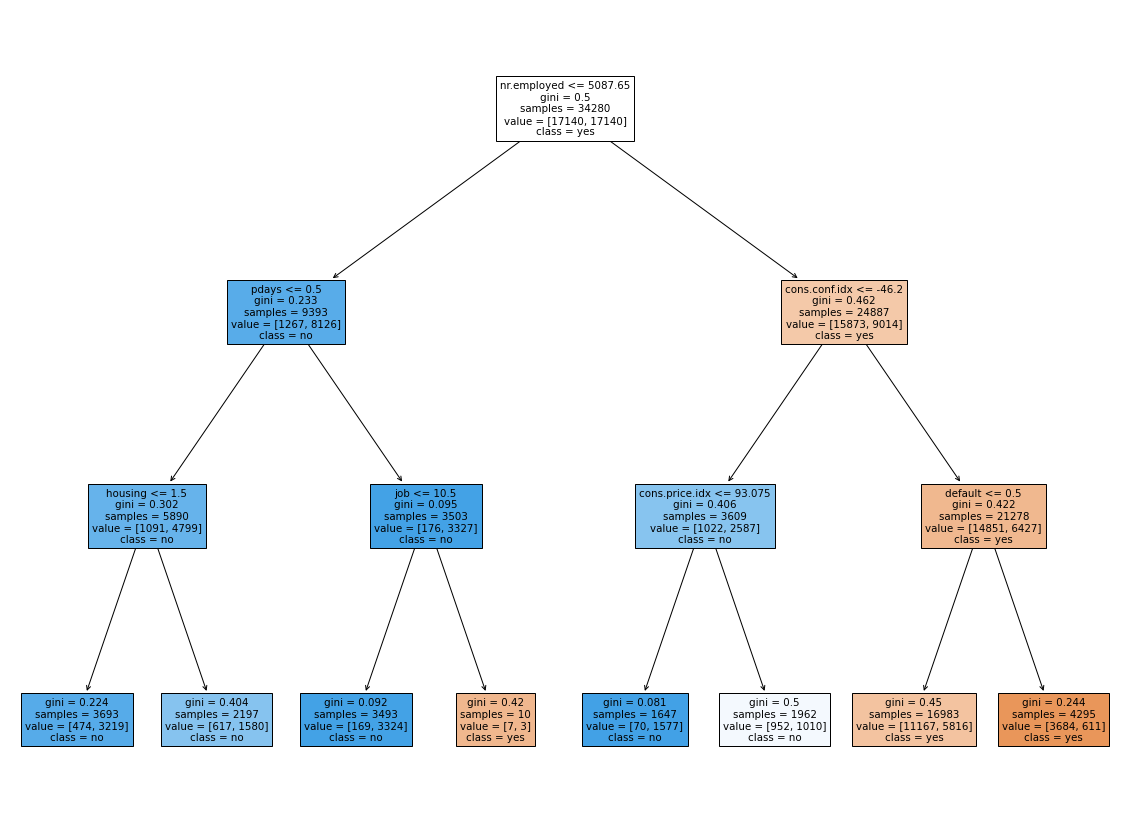

In [28]:
# create a simple version of map for demonstration purpose 
model_map = DecisionTreeClassifier(max_depth=3)
model_map.fit(new_train_X, new_train_y)

from sklearn.tree import plot_tree
plt.figure(figsize=(20,15))
plot_tree(model_map,
          feature_names= df.drop('y', axis=1).columns,  
          class_names= ['yes','no'],
          filled=True)
plt.show()

In [29]:
cv(dt1)   

Accuracy: 0.837 (0.008)


In [30]:
prfs(dt1)

When positive class refers to "running", the precision, recall, f_measure and support for the model is : (0.25885558583106266, 0.35447761194029853, 0.2992125984251969, None)


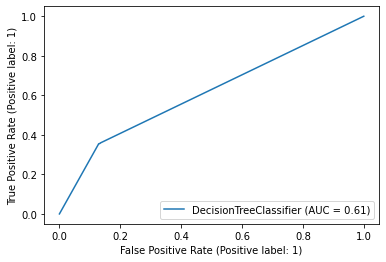

In [31]:
roc_auc(dt1)

### Random forest

In [32]:
rf1 = fit_model(RandomForestClassifier)

training accuracy is: 0.9976371061843641
testing accuracy is: 0.8683131897004729


In [33]:
cv(rf1)

Accuracy: 0.892 (0.007)


In [34]:
prfs(rf1)

When positive class refers to "running", the precision, recall, f_measure and support for the model is : (0.4099502487562189, 0.3843283582089552, 0.39672604718343757, None)


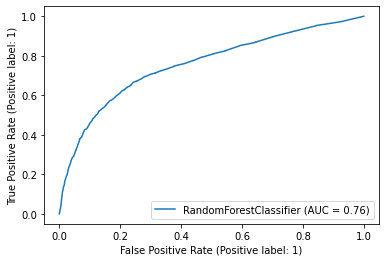

In [35]:
roc_auc(rf1)

### Logistic regression

In [36]:
lr1 = fit_model(LogisticRegression)

training accuracy is: 0.717561260210035
testing accuracy is: 0.7341040462427746


In [37]:
cv(lr1)

Accuracy: 0.898 (0.007)


In [38]:
prfs(lr1)

When positive class refers to "running", the precision, recall, f_measure and support for the model is : (0.25170299727520434, 0.6893656716417911, 0.36876247504990023, None)


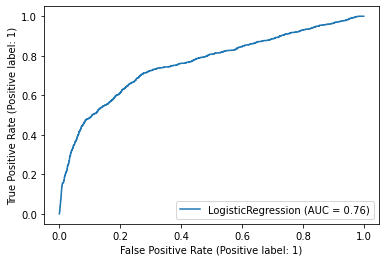

In [39]:
roc_auc(lr1)

### Naive Baysian classifier

In [40]:
# score is too low, drop this method
nb1= fit_model(GaussianNB)

training accuracy is: 0.7287631271878646
testing accuracy is: 0.7536521282186022


### Gradient boosting

In [41]:
gb1 = fit_model(GradientBoostingClassifier)

training accuracy is: 0.8484247374562427
testing accuracy is: 0.8592748292170258


In [42]:
cv(gb1)

Accuracy: 0.899 (0.006)


In [43]:
prfs(gb1)

When positive class refers to "running", the precision, recall, f_measure and support for the model is : (0.4045746962115797, 0.5279850746268657, 0.45811412383650346, None)


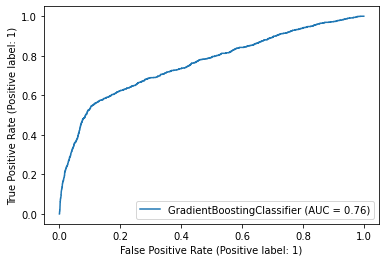

In [44]:
roc_auc(gb1)

### XGBoost Classifier

In [45]:
xgb1 = fit_model(XGBClassifier)

[16:24:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training accuracy is: 0.9413068844807468
testing accuracy is: 0.8759852863899107


In [46]:
cv(xgb1)

Accuracy: 0.896 (0.007)


In [47]:
prfs(xgb1)

When positive class refers to "running", the precision, recall, f_measure and support for the model is : (0.4440993788819876, 0.4001865671641791, 0.4210009813542689, None)


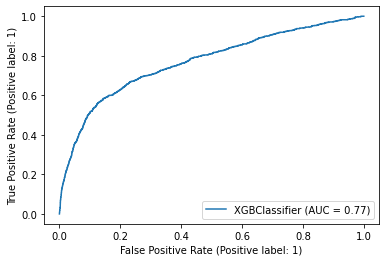

In [48]:
roc_auc(xgb1)

## Feature importance 

In [60]:
# reload the train data
training = pd.read_csv('train_data.csv') 
X_train = training.drop('y',axis=1)
y_train = training['y']

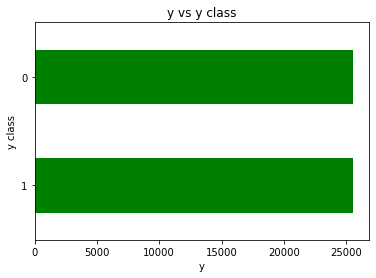

In [61]:
# oversample the minority class, using the SMOTE method
oversample = SMOTE()
new_train_X, new_train_y = oversample.fit_resample(X_train, y_train)

plot_status_numberinit = new_train_y.value_counts().plot(title = 'y vs y class', kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("y")
plot_status_numberinit.set_ylabel("y class")
plt.show()

[18:55:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature: 0, Score: 0.01226
Feature: 1, Score: 0.01226
Feature: 2, Score: 0.01158
Feature: 3, Score: 0.01159
Feature: 4, Score: 0.02033
Feature: 5, Score: 0.01030
Feature: 6, Score: 0.01284
Feature: 7, Score: 0.01260
Feature: 8, Score: 0.03551
Feature: 9, Score: 0.01181
Feature: 10, Score: 0.02543
Feature: 11, Score: 0.03463
Feature: 12, Score: 0.01932
Feature: 13, Score: 0.03748
Feature: 14, Score: 0.01875
Feature: 15, Score: 0.71330


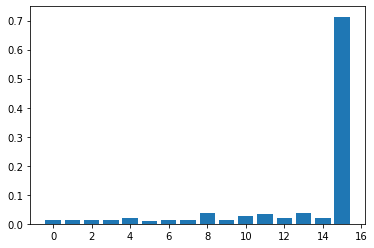

In [72]:
model_XGB = XGBClassifier()

# fit the model
model_XGB.fit(X_train, y_train)

# get importance
importance = model_XGB.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.20120
Feature: 1, Score: 0.09293
Feature: 2, Score: 0.04332
Feature: 3, Score: 0.07943
Feature: 4, Score: 0.01530
Feature: 5, Score: 0.03843
Feature: 6, Score: 0.02712
Feature: 7, Score: 0.08903
Feature: 8, Score: 0.03628
Feature: 9, Score: 0.01616
Feature: 10, Score: 0.03413
Feature: 11, Score: 0.02201
Feature: 12, Score: 0.02427
Feature: 13, Score: 0.02866
Feature: 14, Score: 0.18478
Feature: 15, Score: 0.06694


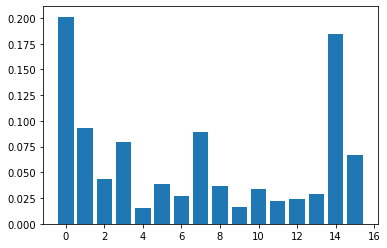

In [73]:
model_rf = RandomForestClassifier()

# fit the model
model_rf.fit(X_train, y_train)

# get importance
importance = model_rf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.02309
Feature: 1, Score: 0.01178
Feature: 2, Score: 0.00133
Feature: 3, Score: 0.00151
Feature: 4, Score: 0.00179
Feature: 5, Score: 0.00130
Feature: 6, Score: 0.00063
Feature: 7, Score: 0.01121
Feature: 8, Score: 0.08440
Feature: 9, Score: 0.00433
Feature: 10, Score: 0.05445
Feature: 11, Score: 0.00729
Feature: 12, Score: 0.02127
Feature: 13, Score: 0.05834
Feature: 14, Score: 0.09268
Feature: 15, Score: 0.62459


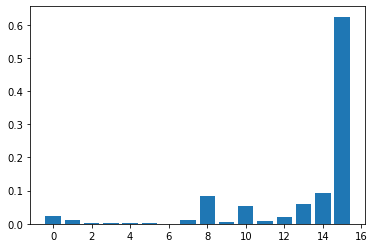

In [74]:
model_gb = GradientBoostingClassifier()

# fit the model
model_gb.fit(X_train, y_train)

# get importance
importance = model_gb.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Fit the real-word test data to the model

In [75]:
# reload the test data
testing = pd.read_csv('test_data.csv')
X_test = testing.drop('y',axis=1)
y_test = testing['y']

In [76]:
# predict result
y_pred = model_rf.predict(X_test)

In [77]:
# change the predict result to 'yes' / 'no'
predict = pd.DataFrame({'pred' : y_pred})
predict['pred'] = predict['pred'].replace([0],'no')
predict['pred'] = predict['pred'].replace([1],'yes')
predict.head()

,pred
0,no
1,no
2,no
3,no
4,yes


In [78]:
# save the final predict result to a new file
pred_result = X_test.join(predict) 
pred_result.to_csv('final_predictions.csv', index=False)

In [79]:
pred_result.head()

,age,job,marital,education,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pred
0,49,9,0,7,0,0,0,1,0,0,1,1.4,94.465,-41.8,4.959,5228.1,no
1,56,1,1,2,1,2,0,2,0,0,1,1.1,93.994,-36.4,4.860,5191.0,no
2,35,9,2,5,0,0,0,1,0,0,1,1.4,94.465,-41.8,4.947,5228.1,no
3,32,1,1,2,1,0,0,2,0,0,1,1.1,93.994,-36.4,4.855,5191.0,no
4,27,11,2,6,0,2,0,4,3,2,2,-1.7,94.055,-39.8,0.767,4991.6,yes
